## Probability Calibration with SplineCalib


This workbook demonstrates the SplineCalib algorithm detailed in the paper
"Spline-Based Probability Calibration" https://arxiv.org/abs/1809.07751

We build a random forest model and demonstrate that using the vote percentage as a probability is not well-calibrated.  We then show different approaches on how to use SplineCalib to appropriately calibrate the model.

We also show how to serialize the calibration object to be able to save it on disk and re-use it.

### MIMIC ICU Data*

We illustrate this process using a mortality model on the MIMIC ICU data

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org

In [1]:
# "pip install ml_insights" in terminal if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score


In the next few cells, we load in some data, inspect it, select columns for our features and outcome (mortality) and fill in missing values with the median of that column.

In [2]:
# Load dataset derived from the MMIC database

lab_aug_df = pd.read_csv("data/lab_vital_icu_table.csv")
lab_aug_df.head(10)

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333
5,71,111944,211832,13.0,30.0,3.6,4.7,17.0,26.0,0.4,...,79.222208,13.0,25.0,17.130435,35.722224,37.833332,37.351852,99.0,100.0,99.862069
6,72,156857,239612,18.0,18.0,NaN,NaN,20.0,20.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78,100536,233150,9.0,9.0,2.7,3.1,26.0,26.0,0.8,...,121.129705,11.0,24.0,16.764706,36.333334,36.833335,36.577778,96.0,100.0,98.470588
8,88,123010,297289,13.0,18.0,NaN,NaN,19.0,26.0,NaN,...,91.884615,9.0,45.0,20.352941,35.722224,39.111112,37.810185,99.0,100.0,99.962963
9,95,160891,216431,13.0,17.0,NaN,NaN,23.0,26.0,NaN,...,93.952386,14.0,20.0,16.363636,35.722224,36.666667,36.305556,96.0,100.0,98.071429


In [3]:
# Choose a subset of variables

X = lab_aug_df.loc[:,['aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
       'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
       'inr_max', 'pt_min', 'pt_max', 'sodium_min', 'sodium_max', 'bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean']]
y = lab_aug_df['hospital_expire_flag']

In [4]:
# Impute the median for in each column to replace NA's 

median_vec = [X.iloc[:,i].median() for i in range(len(X.columns))]

for i in range(len(X.columns)):
    X.iloc[:,i].fillna(median_vec[i],inplace=True)

Now we divide the data into training, calibration, and test sets.  The training set will be used to fit the model, the calibration set will be used to calibrate the probabilities, and the test set will be used to evaluate the performance.  We use a 60-20-20 split (achived by first doing 80/20 and then splitting the 80 by 75/25)

In [5]:
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=0.2, random_state=942)

In [6]:
X_train, X_calib, y_train, y_calib = train_test_split(X_train_calib, y_train_calib, test_size=0.25, random_state=942)

In [7]:
X_train.shape, X_calib.shape, X_test.shape

((35835, 51), (11945, 51), (11946, 51))

Next, we fit a Random Forest model to our training data.  Then we use that model to predict "probabilities" on our validation and test sets.  

I use quotes on "probabilities" because these numbers, which are the percentage of trees that voted "yes" are better understood as mere scores.  A higher value should generally indicate a higher probability of mortality.  However, there is no reason to expect these to be well-calibrated probabilities.  The fact that, say, 60% of the trees voted "yes" on a particular case does not mean that that case has a 60% probability of mortality.

We will demonstrate this empirically later.

In [8]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', random_state=942, n_jobs=-1 )
rfmodel1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=942, verbose=0, warm_start=False)

In [9]:
preds_test_uncalib = rfmodel1.predict_proba(X_test)[:,1]

In [10]:
preds_test_uncalib[:10]

array([0.03 , 0.264, 0.002, 0.138, 0.076, 0.02 , 0.098, 0.026, 0.088,
       0.03 ])

In [11]:
roc_auc_score(y_test, preds_test_uncalib), roc_auc_score(y_test, .1*preds_test_uncalib)

(0.8594278459278996, 0.8594278459278996)

## Model Evaluation
You are pretty happy with this model since it has an AUROC of .859.  But someone asks you if the probability is well-calibrated.  In other words, if we looked at all the time your model predicted a mortality probability of 40%, did around 40% of them actually die?  Or was it 20%, or 80%?  It turns our that AUROC just measures the *ranking* of cases and does not evaluate if the probabilities are meaningful.  In fact, if you multiply all of your predicted probabilities by .1, you would still get the same AUROC.

## Checking Calibration
How do we know if a model is well-calibrated?  One way to check is to create a "Reliability Diagram".  The idea behind the reliability diagram is the following:
- Bin the interval [0,1] into smaller subsets (e.g. [0, 0.05], [0.05, .1], ... [.95,1])
- Find the empirical probabilities when the probabilities fell into each bin  (if there were 20 times, and 9 of them were "yes", the empirical probability is .45)
- Plot the predicted probability (average of predicted probabilities in each bin) (x-axis) vs the empirical probabilities(y-axis)
- put error bars based on the size of the bin
- When the dots are (significantly) above the line y=x, the model is under-predicting the true probability, if below the line, model is over-predicting the true probability.

(array([0.01861123, 0.07227181, 0.12277373, 0.17188113, 0.22222058,
        0.27283966, 0.32543118, 0.37303394, 0.42274797, 0.47114629,
        0.52441667, 0.57909123, 0.62548387, 0.67436364, 0.71878232,
        0.78066667, 0.81781818, 0.86266667, 0.92428571]),
 array([0.01173479, 0.05521706, 0.11971412, 0.20971302, 0.26256983,
        0.29813665, 0.42523364, 0.49350649, 0.51219512, 0.68571429,
        0.625     , 0.76666667, 0.83870968, 0.81818182, 0.94444444,
        1.        , 0.90909091, 0.88888889, 1.        ]),
 array([5113., 2626., 1679.,  906.,  537.,  322.,  214.,  154.,  123.,
          70.,   48.,   30.,   31.,   33.,   18.,   15.,   11.,    9.,
           7.]))

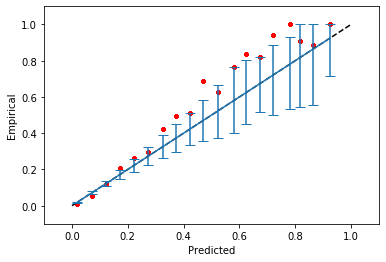

In [12]:
mli.plot_reliability_diagram(y_test, preds_test_uncalib, marker='.')

Above, we see that the model is largely under-predicting the probability of mortality in the range .35 to .85.  For example, when the model predicts a probability of between .6 and .65, more than 80% of those patients died.  And the error bars indicate that this is not likely due to random error.  In other words, our model is poorly calibrated.

## Calibrating a Model
Since our current model is not well-calibrated, we would like to fix this.  We want that when our model says 60% chance of mortality, it means 60% and not 40% or 80%.  We will discuss two ways to fix this:

- Use an independent calibration set
- Using Cross-validation to generate scores from the training set.

The first method is simpler, but requires a separate data set, meaning that you will have less data to train your model with.  It is good to use if you have plenty of data.  It is also a useful approach if you think your distribution has "shifted" but the underlying signal in the model is fundamentally unchanged.  In some cases it may make sense to "re-calibrate" a model on the "current" population without doing a full re-training.

The second approach takes more time, but is generally more data-efficient.  We generate a set of cross-validated predictions on the training data.  These predictions come from models that are close to, but not exactly identical to, your original model.  However, this small disrepancy is usually minor and the calibration approach works well.  For details, see the "Spline-Based Probability Calibration" paper referenced above.

## Approach 1: Independent validation set
First let us demostrate how we would fix this using the independent validation set.

## SplineCalib object
The SplineCalib object is similar in spirit to preprocessors / data transformations in scikit-learn.  The two main operations are `fit` and `calibrate` (akin to `fit` and `transform` in sklearn).

To fit a calibration object, we give it a set of uncalibrated predictions from a model, and the corresponding truth set.  The `fit` routine will learn the spline curve that best maps the uncalibrated scores to actual probabilities.

In [13]:
# Define SplineCalib object

calib1 = mli.SplineCalib()

In [14]:
# Use the model to make predictions on the calibration set
preds_cset = rfmodel1.predict_proba(X_calib)[:,1]

In [15]:
# Fit the calibration object on the calibration set
calib1.fit(preds_cset, y_calib)

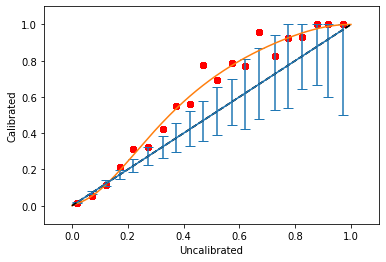

In [16]:
# Visually inspect the quality of the calibration on the calibration set

mli.plot_reliability_diagram(y_calib, preds_cset);
calib1.show_calibration_curve()

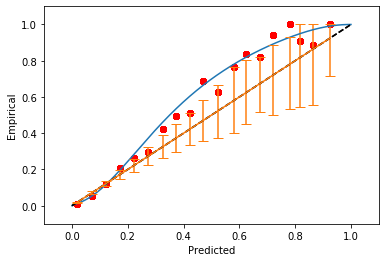

In [17]:
# Visually inspect the quality of the calibration on the test set

calib1.show_calibration_curve()
mli.plot_reliability_diagram(y_test, preds_test_uncalib);

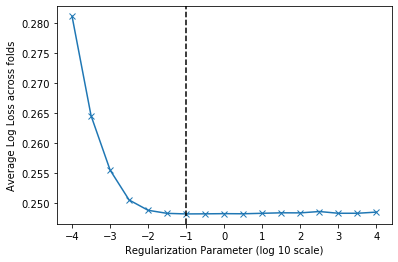

In [18]:
calib1.show_spline_reg_plot()

In [19]:
# Calibrate the previously generated predictions from the model on the test set
preds_test_calib1 = calib1.calibrate(preds_test_uncalib)

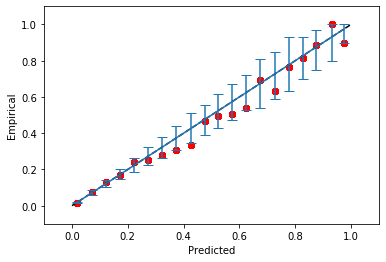

In [20]:
# Visually inspect the calibration of the newly calibrated predictions
mli.plot_reliability_diagram(y_test, preds_test_calib1);

In [21]:
## Compare the log_loss values
log_loss(y_test, preds_test_uncalib),log_loss(y_test, preds_test_calib1)

(0.2525331316238236, 0.24484468382051103)

From the above, we see that not only do our reliability diagrams look better, but our log_loss values have substantially improved.  Log_loss measures not only the *discriminative* power of the model but also how well-calibrated it is.

## Approach 2: Cross-validation on the training data
The reason to use an independent calibration set (rather than just the training data) is that how the model performs on the training data (that it has already seen) is not indicative of how it will behave on data it has not seen before.  We want the calibration to correct how the model will behave on "new" data, not the training data.

Another approach is to take a cross-validation approach to generating calibration data.  We divide the training data into k "folds", leave one fold out, train our model (i.e. the choice of model and hyperparameter settings) on the remaining k-1 folds, and then make predictions on the left-out fold.  After doing this process k times, each time leaving out a different fold, we will have a set of predictions, each of which was generated by 1 of k slightly different models, but was always generated by a model that did not see that training point.  Done properly (assuming no "leakage" across the folds), this set of predictions and answers will serve as an appropriate calibration set.

ML-Insights (the package containing SplineCalib, as well as other functionality) has a simple function to generate these cross-validated predictions.  We demonstrate it below.

In [22]:
# Get the cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(rfmodel1, X_train, y_train, clone_model=True)

In [23]:
calib2 = mli.SplineCalib()
calib2.fit(cv_preds_train, y_train)

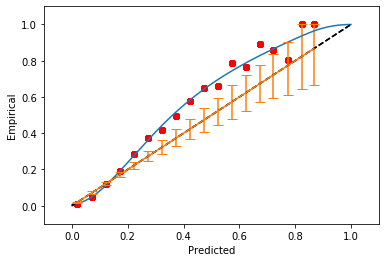

In [24]:
# Show the reliability diagram for the cross-validated predictions, and the calibration curve
calib2.show_calibration_curve()
mli.plot_reliability_diagram(y_train, cv_preds_train[:,1]);

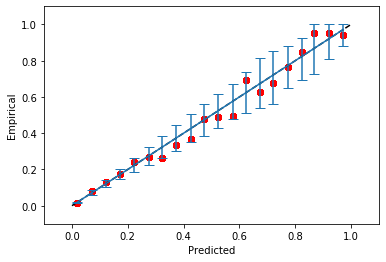

In [25]:
mli.plot_reliability_diagram(y_test, calib2.calibrate(preds_test_uncalib));

In [26]:
preds_test_calib2 = calib2.calibrate(preds_test_uncalib)
log_loss(y_test, preds_test_uncalib), log_loss(y_test, preds_test_calib2)

(0.2525331316238236, 0.2443861652805244)

We see above that the cross-validated approach gives similar performance (slightly better in this case).  Additionally, we did not use the 20% of data set aside for calibration at all in the second approach.  We could use approach 2 on the entire training and calibration data and (presumably) get an even better model.

In [27]:
rfmodel2 = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', random_state=942, n_jobs=-1 )
rfmodel2.fit(X_train_calib,y_train_calib)
preds_test_2_uncalib = rfmodel2.predict_proba(X_test)[:,1]

In [28]:
# Get the cross validated predictions given a model and training data.
cv_preds_train_calib = mli.cv_predictions(rfmodel2, X_train_calib, y_train_calib, stratified=True, clone_model=True)

In [29]:
calib3 = mli.SplineCalib()
calib3.fit(cv_preds_train_calib, y_train_calib)

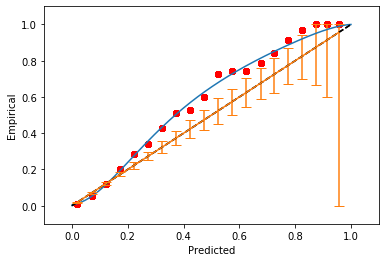

In [30]:
# Show the reliability diagram for the cross-validated predictions, and the calibration curve
calib3.show_calibration_curve()
mli.plot_reliability_diagram(y_train_calib, cv_preds_train_calib[:,1]);

In [31]:
preds_test_calib3 = calib3.calibrate(preds_test_2_uncalib)
log_loss(y_test, preds_test_2_uncalib), log_loss(y_test, preds_test_calib3)

(0.25110679815106546, 0.24302434886987742)

In [32]:
roc_auc_score(y_test, preds_test_2_uncalib), roc_auc_score(y_test, preds_test_calib3)

(0.8617756467135349, 0.8617720059711117)

Indeed, we get a slightly better AUC and log_loss both before and after calibration, due to having a larger training set for our model to learn from

## Serializing Models
The SplineCalib object can be saved to disk easily with `joblib.dump()` and reloaded with `joblib.load()`

In [33]:
import joblib
joblib.dump(calib3, 'calib3.pkl')

['calib3.pkl']

In [34]:
calib3_reloaded=joblib.load('calib3.pkl')

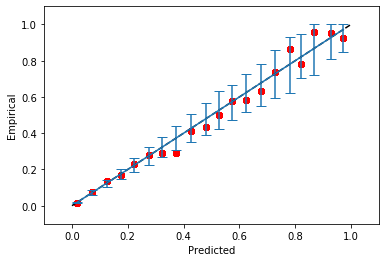

In [35]:
mli.plot_reliability_diagram(y_test, calib3_reloaded.calibrate(preds_test_2_uncalib));

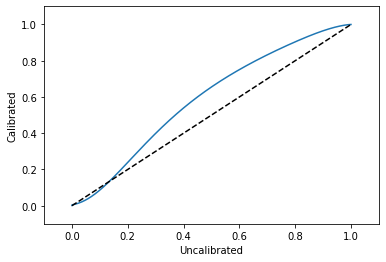

In [36]:
calib3_reloaded.show_calibration_curve()

In [37]:
log_loss(y_test, calib3_reloaded.calibrate(preds_test_2_uncalib))

0.24302434886987742

## Comparison to Other Calibration Approaches

Here we compare SplineCalib to Isotonic Regression, Platt Scaling and Beta Calibration.

In [38]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from betacal import BetaCalibration

In [39]:
# Fit three-parameter beta calibration
bc = BetaCalibration(parameters="abm")
bc.fit(cv_preds_train_calib[:,1], y_train_calib)

# Fit Isotonic Regression
iso = IsotonicRegression()
iso.fit(cv_preds_train_calib[:,1], y_train_calib)

# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999)
lr.fit(cv_preds_train_calib[:,1].reshape(-1,1), y_train_calib)


LogisticRegression(C=99999999999, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

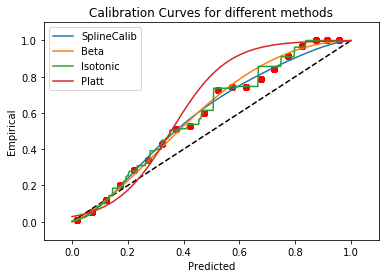

In [40]:
tvec = np.linspace(0,1,1001)
bc_probs = bc.predict(tvec)
iso_probs = iso.predict(tvec)
platt_probs = lr.predict_proba(tvec.reshape(-1,1))[:,1]
splinecalib_probs = calib3.calibrate(tvec)
#calib3.show_calibration_curve()
mli.plot_reliability_diagram(y_train_calib, cv_preds_train_calib[:,1], error_bars=False);
plt.plot(tvec, splinecalib_probs, label='SplineCalib')
plt.plot(tvec, bc_probs, label='Beta')
plt.plot(tvec, iso_probs, label='Isotonic')
plt.plot(tvec, platt_probs, label='Platt')
plt.legend()
plt.title('Calibration Curves for different methods');

In [41]:
preds_test_bc = bc.predict(preds_test_2_uncalib)
preds_test_iso = iso.predict(preds_test_2_uncalib)
preds_test_platt = lr.predict_proba(preds_test_2_uncalib.reshape(-1,1))[:,1]
preds_test_splinecalib = calib3.calibrate(preds_test_2_uncalib)


In [42]:
bc_loss = log_loss(y_test, preds_test_bc)
iso_loss = log_loss(y_test, preds_test_iso)
platt_loss = log_loss(y_test, preds_test_platt)
splinecalib_loss = log_loss(y_test, preds_test_splinecalib)

In [43]:
print('Platt loss       = {}'.format(np.round(platt_loss,5)))
print('Beta Calib loss  = {}'.format(np.round(bc_loss,5)))
print('Isotonic loss    = {}'.format(np.round(iso_loss,5)))
print('SplineCalib loss = {}'.format(np.round(splinecalib_loss,5)))

Platt loss       = 0.25356
Beta Calib loss  = 0.24735
Isotonic loss    = 0.24567
SplineCalib loss = 0.24302
